Imports and setup

In [ ]:
# Deal with the imports and invoke pip if necessary
import torch
try:
  from transformers import (AutoTokenizer, BertConfig,
                            BertForSequenceClassification,
                            BertTokenizer, BertPreTrainedModel,
                            AdamW)
except:
  !pip install transformers
  from transformers import (AutoTokenizer, BertConfig,
                            BertForSequenceClassification,
                            BertTokenizer, BertPreTrainedModel,
                            AdamW)

import pandas as pd
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Ignore UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Run the model on GPU whenever possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name(0)}")

# Initialize RNG's to ensure consistency between runs
random.seed(321)
np.random.seed(321)
torch.manual_seed(321)

# Mount the drive where test.csv and train.csv live
from google.colab import drive
drive.mount('/content/drive')

# Load the files from drive, but use a fraction of the training data so as to
# not overload Colab's GPU RAM
train_df = pd.read_csv(r'/content/drive/MyDrive/train.csv')
test_df = pd.read_csv(r'/content/drive/MyDrive/test.csv')
train_df = train_df[:1500]
test_df = test_df[:500]

# Extract texts and labels from Pandas dataframes
train_texts = train_df['text'].tolist()
train_labels = train_df['sentiment'].map({'neg': 0, 'pos': 1}).tolist()
test_texts = test_df['text'].tolist()
test_labels = test_df['sentiment'].map({'neg': 0, 'pos': 1}).tolist()

Using device: Tesla T4
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def preprocess(texts, labels, tokenizer, max_length):
    input_ids = []
    attention_masks = []

    # For each sentence...
    for text in texts:
        # Encode the text and add `[CLS]` and `[SEP]` tokens.
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        # Add the encoded sentence to the list of input_ids
        input_ids.append(encoded['input_ids'])

        # Add its attention mask (differentiates padding from non-padding) to the list of attention_masks
        attention_masks.append(encoded['attention_mask'])

    # Convert the lists into tensors
    input_ids = torch.cat(input_ids, dim=0).to(device)
    attention_masks = torch.cat(attention_masks, dim=0).to(device)
    labels = torch.tensor(labels).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(input_ids, attention_masks, labels)

    return dataset, input_ids

In [ ]:
def trainAndEvaluate(model, epochs, train_dataloader, test_dataloader,
                     optimizer):
  
  # Initialize performance matrices
  misclassified = []
  accuracies = []
  f1_scores = []
  recalls = []
  precisions = []

  for epoch in range(epochs):
      # ======== Training ======== #
      # Set the model to training mode
      model.train()

      # Initialize variables to track training loss and accuracy
      train_loss = 0.0
      train_accuracy = 0.0
      train_precision = 0.0
      train_recall = 0.0
      train_f1 = 0.0
      num_train_steps = 0

      # Loop through each batch in the training dataloader
      print(f"Training underway for epoch {epoch}...")
      for batch in train_dataloader:
          # Unpack the batch from dataloader
          batch_input_ids = batch[0].to(device)
          batch_attention_masks = batch[1].to(device)
          batch_labels = batch[2].to(device)

          # Clear gradients
          model.zero_grad()        

          # Perform a forward pass (evaluate the model on this training batch)
          model_output = model(input_ids=batch_input_ids, 
                              attention_mask=batch_attention_masks, 
                              labels=batch_labels)

          # The outputs of the model are a tuple of (loss, logits, hidden_states, attentions)
          # We only need the loss and logits to calculate accuracy
          loss = model_output.loss
          logits = model_output.logits

          # Backward pass to calculate gradients
          loss.backward()

          # Update parameters and take a step using the computed gradient
          optimizer.step()

          # Update variables to track training loss and accuracy
          train_loss += loss.item()
          train_accuracy += accuracy_score(batch_labels.cpu(),
                                           logits.argmax(axis=1).cpu())
          train_precision += precision_score(batch_labels.cpu(),
                                             logits.argmax(axis=1).cpu(),
                                             average='weighted')
          train_recall += recall_score(batch_labels.cpu(),
                                       logits.argmax(axis=1).cpu(),
                                       average='weighted')
          train_f1 += f1_score(batch_labels.cpu(),
                               logits.argmax(axis=1).cpu(),
                               average='weighted')
          num_train_steps += 1

      # Calculate the average training loss and accuracy for this epoch
      avg_train_loss = train_loss / num_train_steps
      avg_train_accuracy = train_accuracy / num_train_steps
      avg_train_precision = train_precision / num_train_steps
      avg_train_recall = train_recall / num_train_steps
      avg_train_f1 = train_f1 / num_train_steps

      # ======== Validation ======== #
      # Set the model to evaluation mode
      model.eval()

      # Initialize variables to track validation loss and accuracy
      test_loss = 0.0
      test_accuracy = 0.0
      test_precision = 0.0
      test_recall = 0.0
      test_f1 = 0.0

      num_test_steps = 0

      # Loop through each batch in the validation dataloader
      for batch in test_dataloader:
          # Unpack the batch from dataloader
          batch_input_ids = batch[0].to(device)
          batch_attention_masks = batch[1].to(device)
          batch_labels = batch[2].to(device)

          # Disable gradient calculations to save memory and computation
          with torch.no_grad():
              # Perform a forward pass (evaluate the model on this validation batch)
              model_output = model(input_ids=batch_input_ids, 
                                  attention_mask=batch_attention_masks, 
                                  labels=batch_labels)

              # The outputs of the model are a tuple of (loss, logits, hidden_states, attentions)
              # We only need the loss and logits to calculate accuracy
              loss = model_output.loss
              logits = model_output.logits

              # Get the misclassified sentences by comparing the predicted
              # labels with the true labels, add them to an array for more
              # analysis later. Only do this in the last iteration
              if epoch == (epochs - 1):
                # Get the predicted labels by taking the argmax of the logits
                predicted_labels = logits.argmax(axis=1)
                for i in range(len(batch_labels)):
                    if predicted_labels[i] != batch_labels[i]:
                        input_ids = batch_input_ids[i].detach().cpu().numpy()
                        misclassified.append((input_ids, predicted_labels[i].item(),
                                              batch_labels[i].item(),
                                              model_output.attentions[-1][i].detach().cpu().numpy()))

              # Update variables to track training loss and accuracy
              test_loss += loss.item()
              test_accuracy += accuracy_score(batch_labels.cpu(),
                                               logits.argmax(axis=1).cpu())
              test_precision += precision_score(batch_labels.cpu(),
                                                 logits.argmax(axis=1).cpu(),
                                                 average='weighted')
              test_recall += recall_score(batch_labels.cpu(),
                                           logits.argmax(axis=1).cpu(),
                                           average='weighted')
              test_f1 += f1_score(batch_labels.cpu(),
                                   logits.argmax(axis=1).cpu(),
                                   average='weighted')
              num_test_steps += 1

      # Calculate the average training loss and accuracy for this epoch
      avg_test_loss = test_loss / num_test_steps
      avg_test_accuracy = test_accuracy / num_test_steps
      avg_test_precision = test_precision / num_test_steps
      avg_test_recall = test_recall / num_test_steps
      avg_test_f1 = test_f1 / num_test_steps

      accuracies.append(avg_test_accuracy)
      f1_scores.append(avg_test_f1)
      precisions.append(avg_test_precision)
      recalls.append(avg_test_recall)


      # Output an epoch-by-epoch report
      print(f"Epoch {epoch} __________________________________________________")
      print(f"Train loss: {round(avg_train_loss, 3)}, Train accuracy: {round(avg_train_accuracy, 3)}")
      print(f"Train precision: {round(avg_train_precision, 3)}, Train recall: {round(avg_train_recall, 3)}")
      print(f"Train F1 score: {round(avg_train_f1, 3)}, Train accuracy: {round(avg_train_f1, 3)}")
      print()
      print(f"Test loss: {round(avg_test_loss, 3)}, Test accuracy: {round(avg_test_accuracy, 3)}")
      print(f"Test precision: {round(avg_test_precision, 3)}, Test recall: {round(avg_test_recall, 3)}")
      print(f"Test F1 score: {round(avg_test_f1, 3)}, Test accuracy: {round(avg_test_f1, 3)}")
      print("\n\n")

  return misclassified, [accuracies, precisions, recalls, f1_scores]

In [ ]:
def runModelWithLength(tokenizer, train_texts, train_labels,
                       test_texts, test_labels, length=512,
                       optim=AdamW, learning_rate=3e-6,
                       epochs=5, batch_size=4, use_given_model=False,
                       given_model=None):
  # Initialize performance metric arrays
  
  # Preprocess train and test data and split it up into maximum lengths
  training_data, training_input_ids = preprocess(train_texts, train_labels,
                                                 tokenizer, length)
  test_data, test_input_ids = preprocess(test_texts, test_labels,
                                         tokenizer, length)

  # Load the pre-trained BERT model for sequence classification
  if use_given_model:
    model = given_model
  else:
    model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    num_labels = 2, # Binary classification task
    output_attentions = True, # to display self-attention matrix 
    output_hidden_states = False,
    )

  # Make sure it works on GPU whenever it's available
  model.to(device)

  # Set up the optimizer and learning rate scheduler
  optimizer = AdamW(model.parameters(), lr = learning_rate)
  total_steps = len(training_data) * epochs

  # Set up the data loader for training and testing data
  train_dataloader = DataLoader(training_data, 
                                sampler = RandomSampler(training_data), 
                                batch_size = batch_size)
  test_dataloader = DataLoader(test_data, 
                              sampler = SequentialSampler(test_data), 
                              batch_size = batch_size)
  
  misclassified, performance_list = trainAndEvaluate(model, epochs, train_dataloader, 
                                   test_dataloader, optimizer)

  return (model, training_data, test_data, misclassified,
          performance_list, training_input_ids, test_input_ids)


In [ ]:
# Show the misclassified sentences and their actual labels
def plotSelfAttentions(misclassified, sentence_idx, input_ids):
  decoded_sentence = tokenizer.decode(misclassified[sentence_idx][0], skip_special_tokens=True)
  print(decoded_sentence)
  print(f"Predicted label: {misclassified[sentence_idx][2]}, Actual label: {misclassified[sentence_idx][1]}")
  attention = misclassified[sentence_idx][3]
  print(attention.shape)


  tokens = decoded_sentence.split()
  plt.figure(figsize=(len(tokens), len(tokens)))
  # Find the position of the [PAD] token in the input sequence
  pad_token_pos = np.where(input_ids == tokenizer.pad_token_id)[0][0]

  plt.imshow(attention[-1][:len(tokens), :len(tokens)], cmap='hot', interpolation='nearest')
  plt.xticks(range(len(tokens)), tokens, rotation=90, fontsize=62)
  plt.yticks(range(len(tokens)), tokens, fontsize=62)
  plt.colorbar()
  plt.grid(True)
  plt.xlabel('Input Tokens')
  plt.ylabel('Output Tokens')
  plt.show()

In [ ]:
def plot_metrics(timebase, test_accuracy, f1_scores, precisions, recalls, legends, title):
    print(recalls)
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    metrics = [test_accuracy, f1_scores, precisions, recalls]
    metric_names = ['Test Accuracy', 'F1 Score', 'Precision', 'Recall']

    for i, ax in enumerate(axs.flat):
        metric = metrics[i]
        metric_name = metric_names[i]

        for j, y in enumerate(metric):
            label = legends[j]
            ax.plot(timebase, y, label=label, marker='o', linestyle='--')

        ax.set_title(metric_name)
        ax.legend()
        ax.grid(True)

    fig.suptitle(title, fontsize=16)
    fig.text(0.5, 0.02, 'Epochs', ha='center')
    fig.text(0.04, 0.5, 'Percentage', va='center', rotation='vertical')
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.25, hspace=0.4)
    plt.show()


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
accuracies = []
f1_scores = []
recalls = []
precisions = []

accuracies2 = []
f1_scores2 = []
recalls2 = []
precisions2 = []

In [ ]:
result512 = runModelWithLength(tokenizer, train_texts, train_labels, test_texts,
                                                      test_labels, length=512,
                                                      epochs = 5)

performance_512 = result512[4]
accuracies.append(performance_512[0])
precisions.append(performance_512[1])
recalls.append(performance_512[2])
f1_scores.append(performance_512[3])

In [ ]:
result256 = runModelWithLength(tokenizer, train_texts, train_labels, test_texts,
                                                      test_labels, length=256,
                                                      epochs = 5)

performance_256 = result256[4]
accuracies.append(performance_256[0])
precisions.append(performance_256[1])
recalls.append(performance_256[2])
f1_scores.append(performance_256[3])

In [ ]:
result384 = runModelWithLength(tokenizer, train_texts, train_labels, test_texts,
                                                      test_labels, length=384,
                                                      epochs = 5)

performance_384 = result384[4]
accuracies.append(performance_384[0])
precisions.append(performance_384[1])
recalls.append(performance_384[2])
f1_scores.append(performance_384[3])

[[0.844, 0.866, 0.916, 0.89, 0.926], [0.84, 0.868, 0.872, 0.886, 0.872], [0.818, 0.898, 0.892, 0.886, 0.902]]


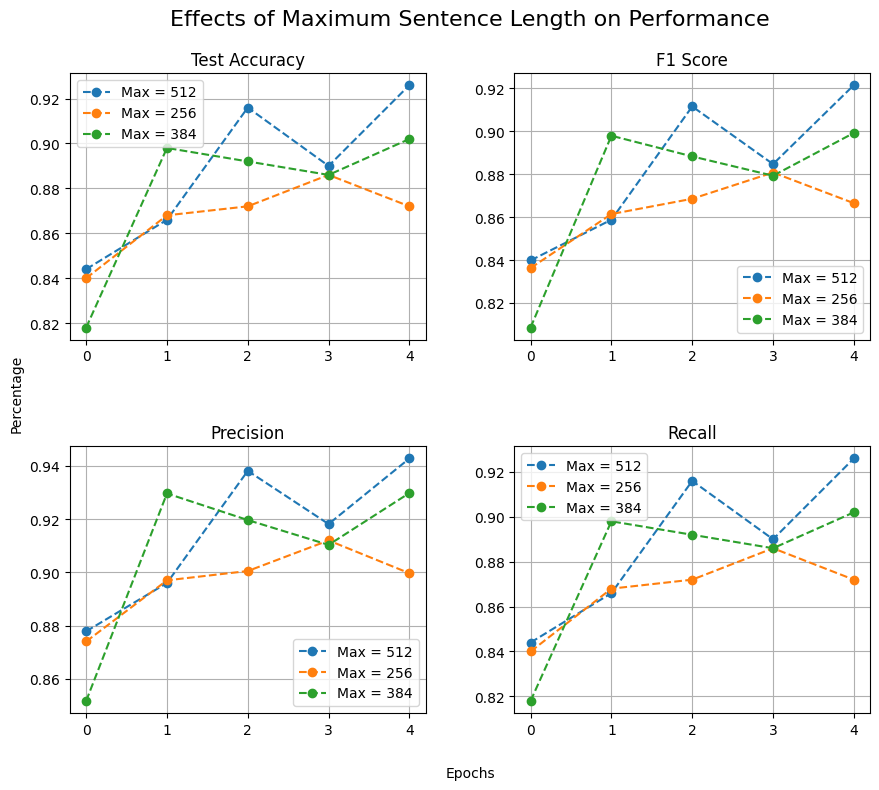

In [ ]:
legends = ['Max = 512', 'Max = 256', 'Max = 384']
title = 'Effects of Maximum Sentence Length on Performance'
timebase = [0, 1, 2, 3, 4]

plot_metrics(timebase, accuracies, f1_scores,
             precisions, recalls, legends, title)

In [ ]:
# Size 512 outperforms the other sizes in every metric, without needing much
# more computation time. If this was an embedded application, maybe 384 would
# have been a good compromise to save memory.
del result256
del result384
torch.cuda.empty_cache()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Next up: learning rates
result3e6 = runModelWithLength(tokenizer, train_texts, train_labels, test_texts,
                               test_labels, length=512, epochs = 5)

performance = result3e6[4]
accuracies2.append(performance[0])
precisions2.append(performance[1])
recalls2.append(performance[2])
f1_scores2.append(performance[3])

In [ ]:
result3e5 = runModelWithLength(tokenizer, train_texts, train_labels, test_texts,
                               test_labels, length=512, epochs = 5,
                               learning_rate=3e-5)

performance = result3e5[4]
accuracies2.append(performance[0])
precisions2.append(performance[1])
recalls2.append(performance[2])
f1_scores2.append(performance[3])

In [ ]:
result7e6 = runModelWithLength(tokenizer, train_texts, train_labels, test_texts,
                               test_labels, length=512, epochs = 5,
                               learning_rate=7e-6)

performance = result7e6[4]
accuracies2.append(performance[0])
precisions2.append(performance[1])
recalls2.append(performance[2])
f1_scores2.append(performance[3])

In [ ]:
result1e5 = runModelWithLength(tokenizer, train_texts, train_labels, test_texts,
                               test_labels, length=512, epochs = 5,
                               learning_rate=1e-5)

performance = result1e5[4]
accuracies2.append(performance[0])
precisions2.append(performance[1])
recalls2.append(performance[2])
f1_scores2.append(performance[3])

[[0.844, 0.866, 0.916, 0.89, 0.926], [0.874, 0.778, 0.896, 0.874, 0.876], [0.86, 0.882, 0.912, 0.908, 0.916], [0.86, 0.914, 0.88, 0.894, 0.888]]
[[0.877833333333333, 0.8959999999999996, 0.9381666666666664, 0.9181666666666662, 0.9428333333333332], [0.9026666666666663, 0.8089999999999996, 0.9319999999999997, 0.914833333333333, 0.9081666666666662], [0.897833333333333, 0.9136666666666664, 0.9374999999999998, 0.9301666666666663, 0.9351666666666665], [0.8878333333333329, 0.9394999999999998, 0.9103333333333331, 0.9044999999999997, 0.9164999999999996]]
[[0.844, 0.866, 0.916, 0.89, 0.926], [0.874, 0.778, 0.896, 0.874, 0.876], [0.86, 0.882, 0.912, 0.908, 0.916], [0.86, 0.914, 0.88, 0.894, 0.888]]
[[0.8398095238095239, 0.8587809523809525, 0.9115428571428573, 0.8846857142857143, 0.9214857142857144], [0.8659428571428573, 0.7570285714285714, 0.897104761904762, 0.8742476190476193, 0.8733333333333334], [0.8551238095238096, 0.8774476190476193, 0.9080761904761905, 0.9048761904761905, 0.9124190476190476]

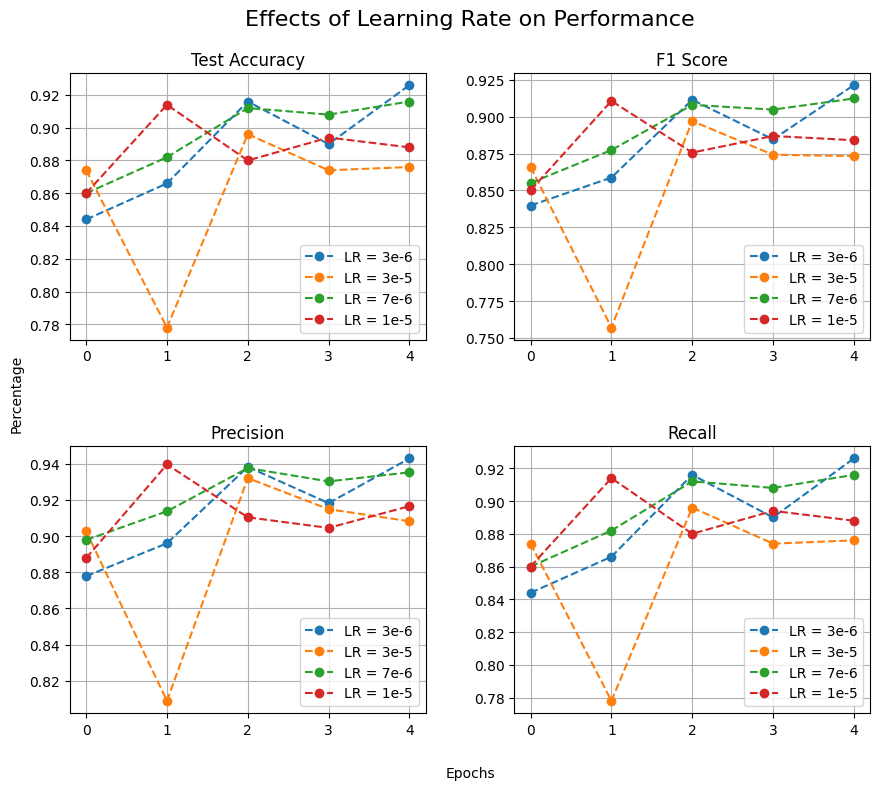

In [ ]:
legends = ['LR = 3e-6', 'LR = 3e-5', 'LR = 7e-6', 'LR = 1e-5']
title = 'Effects of Learning Rate on Performance'
timebase = [0, 1, 2, 3, 4]

print(accuracies2)
print(precisions2)
print(recalls2)
print(f1_scores2)
plot_metrics(timebase, accuracies2, f1_scores2,
             precisions2, recalls2, legends, title)

In [ ]:
# LR = 3e-6 outperforms all other learning rates. This concludes the experiment
# with LR=3e-6, maximum length=512
del result1e5
del result3e5
del result7e6

torch.cuda.empty_cache()